In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet, MultiTaskElasticNet
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
# Silence the SettingWithCopyWarning
warnings.filterwarnings("ignore", category = pd.core.common.SettingWithCopyWarning)

In [2]:
# Load in cleaned data
df = pd.read_csv('/opt/genomics/IPHinvestigators/joyfu/dementia-epilepsy/data/modeling/sample_data_full.csv')

# Separate features (SNPs) and target outcomes
X = df.drop(columns = ['AD', 'LOE'])
y = df[['AD', 'LOE']]

In [3]:
# Placeholder for demographics and SNP columns
demographics = ['age_last_visit', 'female', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
SNP_columns = [col for col in df.columns if col.startswith('chr')]

In [4]:
len(SNP_columns)

4454

# Sample analysis

In [5]:
seed = 701
# Create a composite stratification key
y_stratify = y.apply(lambda row: '_'.join(row.values.astype(str)), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y_stratify, random_state = seed)

## Regress out demographics

In [6]:
# Standardize demographic features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[demographics])
X_test_scaled = scaler.transform(X_test[demographics])

In [7]:
# Regress out demographics from AD and LOE using logistic regression
log_reg_ad = LogisticRegression()
log_reg_ad.fit(X_train_scaled, y_train['AD'])
y_train_pred_ad = log_reg_ad.predict_proba(X_train_scaled)[:, 1]
y_train_resid_ad = y_train['AD'] - y_train_pred_ad

log_reg_loe = LogisticRegression()
log_reg_loe.fit(X_train_scaled, y_train['LOE'])
y_train_pred_loe = log_reg_loe.predict_proba(X_train_scaled)[:, 1]
y_train_resid_loe = y_train['LOE'] - y_train_pred_loe

# Store residuals
y_train_resid = pd.DataFrame({
    'AD_residual': y_train_resid_ad,
    'LOE_residual': y_train_resid_loe
})

In [8]:
# Apply the same transformation to the test set
y_test_pred_ad = log_reg_ad.predict_proba(X_test_scaled)[:, 1]
y_test_resid_ad = y_test['AD'] - y_test_pred_ad

y_test_pred_loe = log_reg_loe.predict_proba(X_test_scaled)[:, 1]
y_test_resid_loe = y_test['LOE'] - y_test_pred_loe

y_test_resid = pd.DataFrame({
    'AD_residual': y_test_resid_ad,
    'LOE_residual': y_test_resid_loe
})

## Modeling

### Single-task Elastic Net

In [9]:
# Isolate SNP data
X_train_SNPs = X_train[SNP_columns]
X_test_SNPs = X_test[SNP_columns]

In [ ]:
# Define the Elastic Net model
elastic_net = ElasticNet()

# Define the grid of hyperparameters to search
param_grid = {
    'alpha': np.logspace(-4, 4, 50),  # Search over a wide range of alpha values
    'l1_ratio': np.linspace(0, 1, 10)  # l1_ratio varies from 0 (Ridge) to 1 (Lasso)
}

# Define the grid search
grid_search = GridSearchCV(estimator = elastic_net, param_grid = param_grid, 
                           cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

In [ ]:
# Fit the grid search to the training data
# == AD prediciton ==
grid_search.fit(X_train_SNPs, y_train_resid['AD_residual'])
# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters for AD: {best_params}")

In [10]:
elnet_ad = ElasticNet(alpha = 0.019, l1_ratio = 0.778) # 0.019, 0.778
elnet_ad.fit(X_train_SNPs, y_train_resid['AD_residual'])
y_pred_ad_resid = elnet_ad.predict(X_test_SNPs)

In [ ]:
# == LOE prediciton ==
grid_search.fit(X_train_SNPs, y_train_resid['LOE_residual'])
# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters for LOE: {best_params}")

In [11]:
elnet_loe = ElasticNet(alpha = 0.019, l1_ratio = 0.778) # 0.019, 0.778
elnet_loe.fit(X_train_SNPs, y_train_resid['LOE_residual'])
y_pred_loe_resid = elnet_loe.predict(X_test_SNPs)

In [12]:
auc_ad_elnet = roc_auc_score(y_test['AD'], y_pred_ad_resid)
auc_loe_elnet = roc_auc_score(y_test['LOE'], y_pred_loe_resid)

auprc_ad_elnet = average_precision_score(y_test['AD'], y_pred_ad_resid)
auprc_loe_elnet = average_precision_score(y_test['LOE'], y_pred_loe_resid)

mse_ad_elnet = mean_squared_error(y_test['AD'], y_pred_ad_resid)
mse_loe_elnet = mean_squared_error(y_test['LOE'], y_pred_loe_resid)

print(f"Elastic net AUC for AD: {auc_ad_elnet}, AUPRC for AD: {auprc_ad_elnet}, MSE for AD: {mse_ad_elnet}")
print(f"Elastic net AUC for LOE: {auc_loe_elnet}, AUPRC for LOE: {auprc_loe_elnet}, MSE for LOE: {mse_loe_elnet}")

Elastic net AUC for AD: 0.6610615799295045, AUPRC for AD: 0.30568553861680764, MSE for AD: 0.14395508220492736
Elastic net AUC for LOE: 0.5424679487179487, AUPRC for LOE: 0.13929379322387808, MSE for LOE: 0.1197040841532493


###  Multi-task Elastic Net

In [ ]:
# Define the Multitask Elastic Net model
multi_task_elastic_net = MultiTaskElasticNet()

# Define the grid of hyperparameters to search
param_grid = {
    'alpha': np.logspace(-4, 4, 50),  # Search over a wide range of alpha values
    'l1_ratio': np.linspace(0, 1, 10)  # l1_ratio varies from 0 (Ridge) to 1 (Lasso)
}

# Define the grid search
grid_search = GridSearchCV(estimator = multi_task_elastic_net, param_grid = param_grid, 
                           cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

In [ ]:
# Fit the grid search to the training data
grid_search.fit(X_train_SNPs, y_train_resid)
# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters (multi-task Elastic Net): {best_params}")

In [13]:
# Train Multi-Task Lasso model with the best alpha
multi_task_elnet = MultiTaskElasticNet(alpha = 0.019, l1_ratio = 0.667) # 0.019, 0.667
multi_task_elnet.fit(X_train_SNPs, y_train_resid)
y_pred_resid_multi_task = multi_task_elnet.predict(X_test_SNPs)

In [14]:
auc_ad_multi_task = roc_auc_score(y_test['AD'], y_pred_resid_multi_task[:, 0])
auc_loe_multi_task = roc_auc_score(y_test['LOE'], y_pred_resid_multi_task[:, 1])

auprc_ad_multi_task = average_precision_score(y_test['AD'], y_pred_resid_multi_task[:, 0])
auprc_loe_multi_task = average_precision_score(y_test['LOE'], y_pred_resid_multi_task[:, 1])

mse_ad_multi_task = mean_squared_error(y_test['AD'], y_pred_resid_multi_task[:, 0])
mse_loe_multi_task = mean_squared_error(y_test['LOE'], y_pred_resid_multi_task[:, 1])

print(f"Multi-Task Elnet AUC for AD: {auc_ad_multi_task}, AUPRC for AD: {auprc_ad_multi_task}, MSE for AD: {mse_ad_multi_task}")
print(f"Multi-Task Elnet AUC for LOE: {auc_loe_multi_task}, AUPRC for LOE: {auprc_loe_multi_task}, MSE for LOE: {mse_loe_multi_task}")

Multi-Task Elnet AUC for AD: 0.6581380883267676, AUPRC for AD: 0.3206370145788535, MSE for AD: 0.1433962673567193
Multi-Task Elnet AUC for LOE: 0.6368689903846154, AUPRC for LOE: 0.2082893434412605, MSE for LOE: 0.11874117425486665


### Plot

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [16]:
# Calculate Precision-Recall curves and AUPRCs
precision1, recall1, _ = precision_recall_curve(y_test['AD'], y_pred_ad_resid)
auprc1 = auc(recall1, precision1)

precision2, recall2, _ = precision_recall_curve(y_test['AD'], y_pred_resid_multi_task[:, 0])
auprc2 = auc(recall2, precision2)

precision3, recall3, _ = precision_recall_curve(y_test['LOE'], y_pred_loe_resid)
auprc3 = auc(recall3, precision3)

precision4, recall4, _ = precision_recall_curve(y_test['LOE'], y_pred_resid_multi_task[:, 1])
auprc4 = auc(recall4, precision4)

<Figure size 640x480 with 0 Axes>

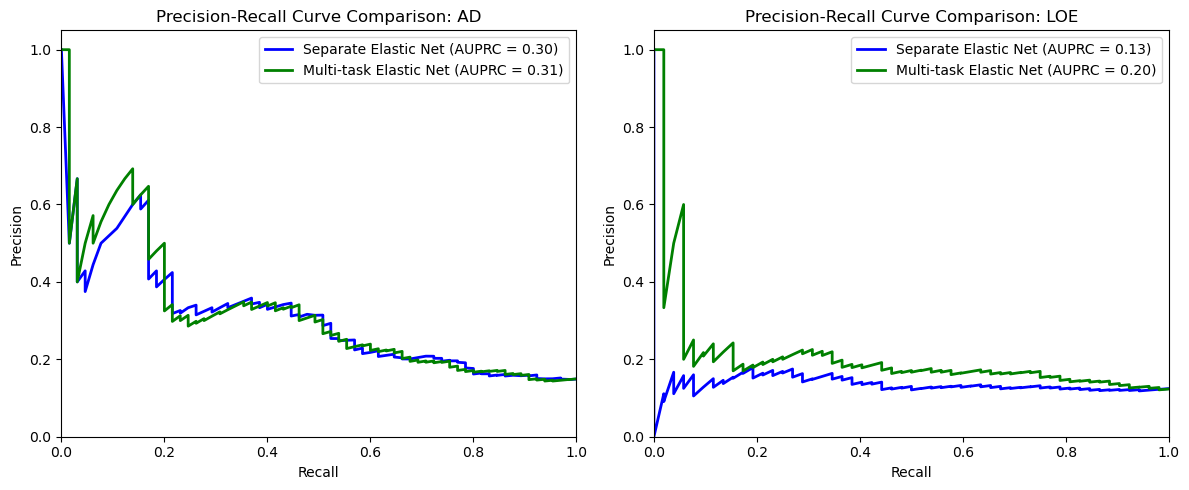

In [37]:
# Plot Precision-Recall curves
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall1, precision1, color = 'blue', lw = 2, label = f'Separate Elastic Net (AUPRC = {auprc1:.2f})')
plt.plot(recall2, precision2, color = 'green', lw = 2, label = f'Multi-task Elastic Net (AUPRC = {auprc2:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: AD')
plt.legend(loc = "upper right")

plt.subplot(1, 2, 2)
plt.plot(recall3, precision3, color = 'blue', lw = 2, label = f'Separate Elastic Net (AUPRC = {auprc3:.2f})')
plt.plot(recall4, precision4, color = 'green', lw = 2, label = f'Multi-task Elastic Net (AUPRC = {auprc4:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: LOE')
plt.legend(loc = "upper right")

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("model_comparison_plot.png", dpi = 300)

# Optionally, display the plot
plt.show()

# Shared risk score

In [19]:
# Load in shared SNPs data
shared_feature = pd.read_csv('/opt/genomics/IPHinvestigators/joyfu/dementia-epilepsy/data/modeling/rsID_shared.txt',
                             delimiter='\t')
print(shared_feature.shape) # dim = (83,15)
shared_feature.head()

(83, 15)


,SNP,n,rsID,phenotype,chr_num,pos,CADD,nearestGene,func,posMapFilt,eqtlMapFilt,ciMapFilt,mean_AD_coef,mean_LOE_coef,signs
0,chr19:44885243:A:G,999,rs283811,AD_EUR,19,44885243,0.900,PVRL2:CTB-129P6.4,ncRNA_intronic,1,0,0,0.061982,-0.000172,Different
1,chr19:44820881:G:A,998,rs28399637,AD_EUR,19,44820881,0.114,BCAM,intronic,1,0,0,0.015581,0.003028,Same
2,chr19:44901715:T:C,994,rs1038025,AD_EUR,19,44901715,2.561,TOMM40,UTR3,1,0,0,-0.014890,-0.002215,Same
3,chr11:86103444:G:T,881,rs586274,AD_EUR,11,86103444,1.993,snoU13,intergenic,1,0,1,-0.009505,0.004077,Different
4,chr1:207627064:T:A,807,rs12028134,AD_EUR,1,207627064,1.972,CR1,intronic,1,0,0,0.006167,-0.002626,Different


In [20]:
filtered_df = shared_feature[shared_feature['signs'] == 'Same']
# Select the "SNP" column as a NumPy array
snp_array = filtered_df['SNP'].to_numpy()

## Retrain model with shared SNPs

In [21]:
# Load in cleaned data
df = pd.read_csv('/opt/genomics/IPHinvestigators/joyfu/dementia-epilepsy/data/modeling/sample_data_full.csv')
# Create a new column 'AD_LOE' based on the conditions
df['AD_LOE'] = ((df['AD'] == 1) | (df['LOE'] == 1)).astype(int)
# Separate features (SNPs) and target outcomes
X = df.drop(columns = ['AD', 'LOE', 'AD_LOE'])
y = df[['AD_LOE']]

In [22]:
df['AD_LOE'].value_counts()

0    1609
1     570
Name: AD_LOE, dtype: int64

In [23]:
# Placeholder for demographics and SNP columns
demographics = ['age_last_visit', 'female', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
SNP_columns = snp_array
len(SNP_columns)

27

In [24]:
seed = 701
# Create a composite stratification key
y_stratify = y.apply(lambda row: '_'.join(row.values.astype(str)), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y_stratify, random_state = seed)

In [26]:
# Standardize demographic features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[demographics])
X_test_scaled = scaler.transform(X_test[demographics])
# Regress out demographics from AD and LOE using logistic regression
log_reg_ad_loe = LogisticRegression()
log_reg_ad_loe.fit(X_train_scaled, y_train['AD_LOE'])
y_train_pred_ad_loe = log_reg_ad_loe.predict_proba(X_train_scaled)[:, 1]
y_train_resid_ad_loe = y_train['AD_LOE'] - y_train_pred_ad_loe

# Store residuals
y_train_resid = pd.DataFrame({
    'residual': y_train_resid_ad_loe
})

In [27]:
# LASSO model (with all features fixed in the model)
# Isolate SNP data
X_train_SNPs = X_train[SNP_columns]
X_test_SNPs = X_test[SNP_columns]

In [30]:
lasso_ad_loe = Lasso(alpha = 0) 
lasso_ad_loe.fit(X_train_SNPs, y_train_resid['residual'])

y_pred_ad_loe_resid = lasso_ad_loe.predict(X_test_SNPs)

<ipython-input-30-47e9080bd5e8>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_ad_loe.fit(X_train_SNPs, y_train_resid['residual'])
/home2/mingzhoufu/.conda/envs/jf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home2/mingzhoufu/.conda/envs/jf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.30934337014676, tolerance: 0.03153826100259746
  model = cd_fast.enet_coordinate_descent(


In [31]:
auc_lasso = roc_auc_score(y_test['AD_LOE'], y_pred_ad_loe_resid)
auprc_lasso = average_precision_score(y_test['AD_LOE'], y_pred_ad_loe_resid)
mse_lasso = mean_squared_error(y_test['AD_LOE'], y_pred_ad_loe_resid)

print(f"Lasso AUC: {auc_lasso}, AUPRC: {auprc_lasso}, MSE: {mse_lasso}")

Lasso AUC: 0.6560422796120737, AUPRC: 0.4292944496445104, MSE: 0.2507434060489487


In [32]:
coefficients = pd.DataFrame(lasso_ad_loe.coef_.T, index = SNP_columns, columns = ['AD_LOE_coef'])
# Identify feature coefficients 
coef_features = coefficients[(coefficients['AD_LOE_coef'] != 0) ]
coef_features.shape

(27, 1)

In [34]:
coef_features.to_csv('/opt/genomics/IPHinvestigators/joyfu/dementia-epilepsy/output/coef_features_retrain.csv', index = True)